# 1. `tf.data` input pipelines for PyTorch

Here we use a `tf.data` dataset to load torch tensors to the GPU.
When the `tf.data` dataset is defined, tensorflow preallocates a memory pool for the dataset on the GPU (that would be \~1101MB for the data used in this notebook).

When doing `.to(device)` to a torch tensor, the torch tensor is allocated on that memory pool. The time measured for 800 batches is around 400 miliseconds. The same thing with only pytorch takes \~2.7 seconds and the same amount of GPU memory is used.

The idea used in this notebook comes from the Kaggle notebook [TF-DS for PyTorch](https://www.kaggle.com/hirotaka0122/tf-ds-for-pytorch).

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import torch
import tensorflow as tf
import tensorflow_datasets as tfds

In [3]:
tf.version.VERSION

'2.7.0'

In [4]:
gpus = tf.config.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

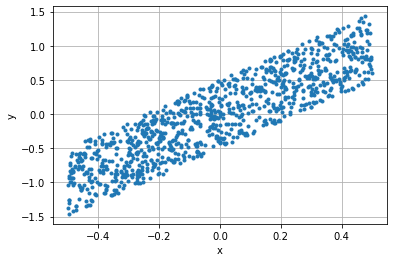

In [5]:
# Create a linear function with noise as our data
nsamples = 1000
ref_slope = 2.0
ref_offset = 0.0
noise = np.random.random((nsamples, 1)) - 0.5    # -0.5 to center the noise
x_train = np.random.random((nsamples, 1)) - 0.5  # -0.5 to center x around 0
y_train = ref_slope * x_train + ref_offset + noise

plt.plot(x_train, y_train, '.')
plt.xlabel('x')
plt.ylabel('y')
plt.grid()
plt.show()

In [7]:
dataset = tf.data.Dataset.from_tensor_slices((x_train.astype(np.float32),
                                              y_train.astype(np.float32)))
dataset = dataset.shuffle(1000)  # shuffle by chunks of 1000 samples. In this case, that's the how dataset.
dataset = dataset.batch(128)     # set the batch size
# dataset = dataset.prefetch(100)
dataset = dataset.repeat(100)    # set the number of epocs

In [8]:
dataset_np = tfds.as_numpy(dataset)

In [9]:
%%time

device = 0
for x, y in dataset_np:
    x_dev = torch.tensor(x).to(device)
    y_dev = torch.tensor(y).to(device)

CPU times: user 398 ms, sys: 8.67 ms, total: 407 ms
Wall time: 401 ms


In [10]:
x_dev.device

device(type='cuda', index=0)